# Template data analysis Workflow - Visualization and kinetic Modeling of enzymatic data

### Imports
Import packages needed for data analysis and set global varibales used in this notebook

In [1]:
import os # operating system to work with directories and files
import matplotlib.pyplot as plt # plot data and results
import seaborn as sns # prettier visualization
import pandas as pd # convert excel to dataframe
import numpy as np # convert dataframe to nparray for solver

from scipy.integrate import odeint # solve ode
from lmfit import minimize, Parameters, Parameter, report_fit # fitting

from pyenzyme import EnzymeMLDocument # EnzymeML document functionalities

#sns.set(style="whitegrid")

## Select EnzymeML document
Select the EnzymeML document, by changing the path variable accodingly. <br>
The whole EnzymeML document is stored in the enzmldoc variable. <br>

In [2]:
# If the document is a Omex file
enzmldoc = EnzymeMLDocument.fromFile('./0.5mM_NAG_0.05mM_NAGOX.omex')

# If the document is a Excel file
#enzmldoc = EnzymeMLDocument.fromTemplate('path_to.xlsx')

## Print the Document to get a first overview

In the "Reactants" section you can see which IDs are given to the reactants.
This is for modeling important because we can choose which reactant we want to model.

In [3]:
# With measurements=True in parenthesis we can also print out the initial concentrations 
enzmldoc.printDocument()

0.5mM_NAG_0.05mM_NAGOX
>>> Reactants
	ID: s0 	 Name: Oxygen
	ID: s1 	 Name: N-acetyl-D-glucosamine
	ID: s2 	 Name: Hydrogen peroxide
	ID: s3 	 Name: N-acetyl-D-glucosaminolactone
>>> Proteins
	ID: p0 	 Name: N-acetylglucosamine oxidase (NagOx)
>>> Complexes
>>> Reactions
	ID: r0 	 Name: N-acetylglucosamine conversion


## Visualization of time-course data
A short visualisation to get a first impression of the data. <br>

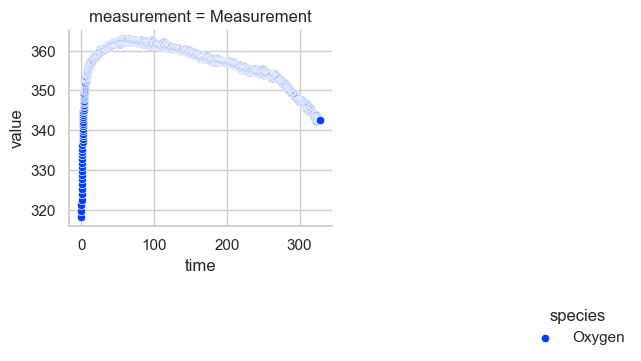

In [4]:
#basic/general settings for Seaborn
sns.set_theme(style='whitegrid', palette ='bright',color_codes=True, context = 'notebook')

enzmldoc.visualize(sharey=False, use_names=True, height=3.75)

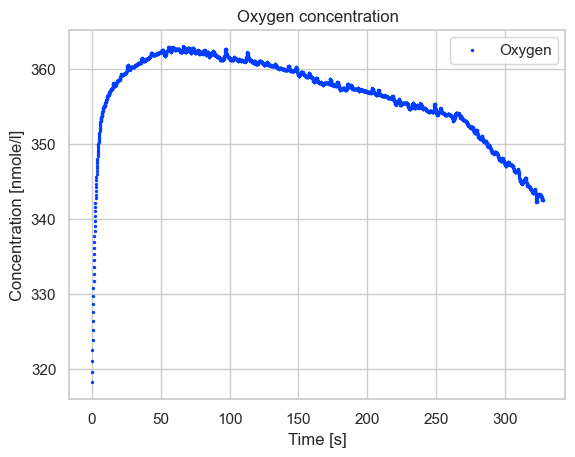

In [62]:
plt.scatter(data_time[0], data_s[0], label="Oxygen", s=2)
plt.xlabel("Time [s]")
plt.ylabel("Concentration [nmole/l]")
plt.title('Oxygen concentration')
plt.legend()

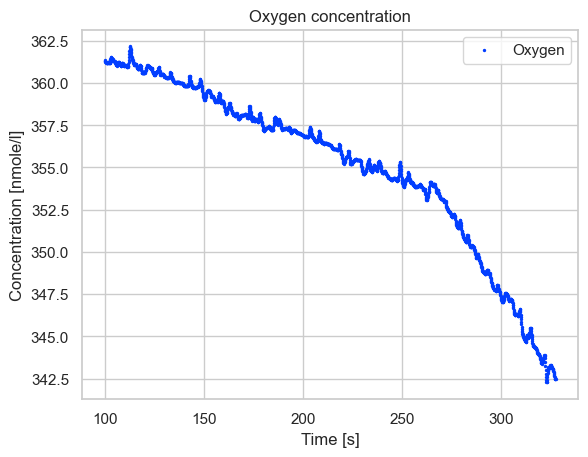

In [65]:
plt.scatter(data_time[0][1000:], data_s[0][1000:], label="Oxygen", s=2)
plt.xlabel("Time [s]")
plt.ylabel("Concentration [nmole/l]")
plt.title('Oxygen concentration')
plt.legend()

## Prepare the data for modeling

Which Reactant should be modeled?

In [5]:
reactant_id = 's0'

In [49]:
# Check if reactant_id is present
if reactant_id not in enzmldoc.getSpeciesIDs():
    print('Species not present')
    
# Exports species specific measurement data (dictionary)
data = enzmldoc.exportMeasurementData(species_ids=reactant_id)

# Concatenate data to a single DataFrame
data = pd.concat([meas["data"] for meas in data.values()])

# Separate time and actual values to ndarrays
# Reshape to match measurements
data_time = data.time.values.reshape(-1, len(data.time.values)) # "-1" because it's an unknown dimension and we want numpy to figure it out
data_time = np.round(data_time, 2)
data_s = data[reactant_id].values.reshape(-1, len(data[reactant_id].values))#[0, :] # -> converts 2D array to 1D  

print(f"Shape of data: {data_s.shape}\nShape of time: {data_time.shape}")

Shape of data: (1, 3277)
Shape of time: (1, 3277)


## Kinetic modeling and parameter estimation

In order to model the data and perform parameter fitting, the kinetic equation for the model is defined as a Python function, along with a function to calculate the residual between the model and the measured data. <br>
<br>
In this case it is the Michaelis-Menten equation for one substrate that we want to model

In [29]:
def michaelis_menten(w, t, params):
    '''
    Differential equations
    Arguments:
        w: vector of state variables, here only one: w = [S]
        t: time
        params: parameters
    '''
    s = w
    
    vmax = params['vmax'].value
    km = params['Km'].value
    
    # f(s'):
    f1 = -vmax * s / (km + s) # S'
    return f1

In [30]:
def g(t, w0, params):
    '''
    Solution to the ODE w'(t)=f(t,w,p) with initial condition w(0)= w0 (= [S0])
    '''
    w = odeint(michaelis_menten, w0, t, args=(params,))
    return w

#### Compute residual between actual data (S) and fitted data

In [31]:
def residual(params, t, data_s):
    
    ndata, nt = data_s.shape # get dimensions of data (here we fit against 4 measurments => ndata = 4)
    resid = 0.0 * data_s[:] # initialize the residual vector
    
    # compute residual per data set
    for i in range(ndata):
        
        w0 = data_s[i,0]
        model = g(t, w0, params) # solve the ODE with the given parameters
        
        # get modeled substrate
        s_model = model[:,0]
        resid[i,:]=data_s[i,:]-s_model # compute distance to measured data
        
    return resid.flatten()

In [32]:
def residual_single(params, t, data_s):
    
    w0 = data_s[0] # first value of measurement
    model = g(t, w0, params) # g -> solving ODE 
    
    # only have data for s not v
    s_model = model[:,0] # 0th column
    
    return (s_model - data_s).ravel()

#### Functions to compute initial value for vmax and Km
To get a good guess for vmax, v is computed for each time step. <br>
For Km the mean of s values at aproximatly vmax/2 is taken.

In [33]:
def get_v(time, data_s):
    
    v_all = 0.0*data_s[:] # initialize velocity vector
    
    if len(data_s.shape)>1:
        
        for i in range(data_s.shape[0]):
            
            prev_value = data_s[i,0]
            prev_time = 0.0
            
            for j in range(data_s.shape[1]):
                
                if time[j] == 0:
                    delta = prev_value - data_s[i,j]
                else:
                    delta = abs( (prev_value - data_s[i,j])/(time[j]-prev_time))
                
                v_all[i,j] = delta
                prev_value = data_s[i,j]
                prev_time = time[j]
                
        v = np.max(v_all, axis=0)
        
    else:
        
        prev_value = data_s[0]
        prev_time = 0.0
        
        for j in range(data_s.shape[0]):
            
            if time[j] == 0:
                delta = prev_value - data_s[j]
            else:
                delta = abs( (prev_value - data_s[j])/(time[j]-prev_time))
            
            v_all[j] = delta
            prev_value = data_s[j]
            prev_time = time[j]
            
        v = v_all
        
    return v

In [34]:
def get_initial_vmax(time, data_s):
    v = get_v(time,data_s)
    return np.max(v)

In [35]:
def get_initial_Km(time, data_s):
    
    v = get_v(time,data_s)
    idx_max = np.where(v == np.max(v))[0][0]
    idx_Km = (np.abs(v[idx_max:]-np.max(v)/2)).argmin()
    
    if len(data_s.shape)>1:
        km = np.mean(data_s,axis=0)[idx_max+idx_Km]
    else:
        km = data_s[idx_max+idx_Km]
    
    return km

#### Modeling function

In [36]:
def modeling(data_s, t_measured, params):
    if len(data_s.shape)>1:
        result = minimize(residual , params, args=(t_measured, data_s), method='leastsq')
        report_fit(result) # access values of fitted parameters: result.params['Km'].value
        # plot the data sets and fits
        plt.figure()
        for i in range(data_s.shape[0]):
            plt.plot(t_measured, data_s[i, :], 'o')
            #w0 = params['v0'].value, data_s[i,0]
            w0 = data_s[i,0]
            data_fitted = g(t_measured, w0, result.params)
            plt.plot(t_measured, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
        plt.show()
    
    else:
        result = minimize(residual_single , params, args=(t_measured, data_s), method='leastsq')
        report_fit(result) # access values of fitted parameters: result.params['Km'].value
        # plot the data sets and fits
        plt.figure()
        plt.plot(t_measured, data_s[:], 'o')
        w0 = data_s[0]
        data_fitted = g(t_measured, w0, result.params)
        plt.plot(t_measured, data_fitted[:, 0], '-', linewidth=2, label='fitted data')
        plt.show()

#### Initialize parameters:

In [37]:
def init_params(data_s, data_time):
    # time
    #t_measured = data_time

    # initial conditions:
    if len(data_s.shape)>1: # pick the first measurement of data_s, if multidimensional array then first prep the array
        s0 = np.max(data_s,axis=0)[0]
    else:
        s0 = data_s[0] # pick the first measurement of data_s

    # Set parameters including bounds
    vmax = get_initial_vmax(data_time, data_s)
    km = get_initial_Km(data_time, data_s)

    params = Parameters()
    params.add('vmax', value=vmax, min=0.0001, max=100.) # max = Wie am besten wählen?
    params.add('Km', value=km, min=0.01, max=s0) 
    return params

#### Fit model and visualize results
Statistics for the Fit and the parameters are printed. <br>
In the graph the red line shows the result of the model. <br>
The dotted curves are the measured data sets.

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 72
    # data points      = 2277
    # variables        = 2
    chi-square         = 2.1856e+08
    reduced chi-square = 96070.7362
    Akaike info crit   = 26125.6559
    Bayesian info crit = 26137.1171
[[Variables]]
    vmax:  5.00000028 +/- 0.88247442 (17.65%) (init = 100)
    Km:    15.0000000 +/- 1.48477614 (9.90%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(vmax, Km) = 0.957


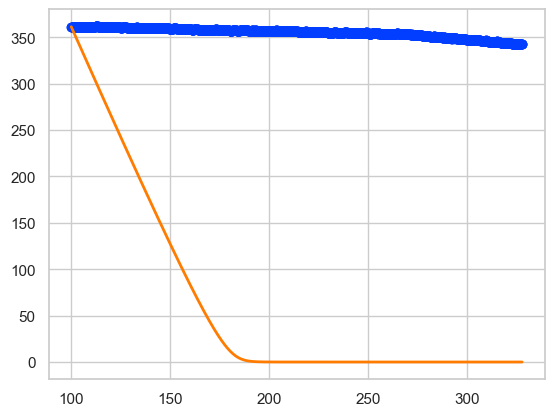

In [66]:
#params = init_params(data_s, data_time)
params = Parameters()
params.add(name="vmax", value=100, min=5, max=400)
params.add(name="Km", value=1, min=0.001, max=15)
modeling(data_s[0][1000:], data_time[0][1000:], params)